- 사회적 불안지수 만들어야함
- 이혼율, 자살률, 1인가구율 등 단위와 범위가 다른 변수들을 0~1 사이의 같은 스케일로 맞추기 위해 정규화를 진행함
- 연관성에 대해서는 상관관계를 분석함
- 자치구 기준으로 병합
- 봉사활동 지표는 역정규화 처리
- mean으로 정규화된 지표를 계산한다. 

In [2]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 기본 테마 설정
# https://coldbrown.co.kr/2023/07/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EC%8B%A4%EC%A0%84%ED%8E%B8-08-seaborn-sns-set%EC%9D%84-%ED%86%B5%ED%95%B4-%EC%8A%A4%ED%83%80%EC%9D%BC-%EC%84%A4%EC%A0%95%ED%95%98%EA%B8%B0/
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 복잡한 통계 처리를 위한 라이브러리
from scipy import stats

# 필요한 패키지
import os

In [3]:
# 현재 경로 확인
os.getcwd()


'c:\\Users\\admin\\Desktop\\mid_project\\MidProject\\members\\조준혁\\notebook'

In [4]:

# 상위 폴더로 이동
os.chdir('../../')

In [5]:
os.chdir(r'C:/Users/admin/Desktop/mid_project/MidProject')

In [6]:
# 현재 경로 확인
os.getcwd()


'C:\\Users\\admin\\Desktop\\mid_project\\MidProject'

In [7]:
# 예시 파일 경로들
df_divorce = pd.read_csv('data/processed/혼인이혼_동별.csv')          # 이혼율
df_single = pd.read_csv('data/processed/1인가구합.csv')         # 1인가구
df_dropout = pd.read_csv('data/processed/2023 구별 학업 중단율.csv')       # 학업중단율
df_suicide = pd.read_csv('data/processed/자살율통계_서울시울시2023.csv')          # 자살률
df_volunteer = pd.read_csv('data/processed/2023_봉사활동_등록현황.csv')       # 봉사활동 수

In [8]:
#데이터를 확인한다.
df_divorce.head()

,자치구별,2023,2023.1
0,자치구별,혼인,이혼
1,종로구,440,199
2,중구,595,197
3,용산구,1002,312
4,성동구,1280,340


In [9]:
# 컬럼 이름을 바꿔준다.
df_divorce = df_divorce.rename(columns={'2023': '혼인',
                                        '2023.1' : '이혼'})
# 그리고 0번 raw는 필요없기 때문에 빼고 만들들겠다. 
df_divorce = df_divorce[(df_divorce['자치구별'] != '자치구별')]

# 데이터프레임을 확인한다. 
df_divorce.head()

,자치구별,혼인,이혼
1,종로구,440,199
2,중구,595,197
3,용산구,1002,312
4,성동구,1280,340
5,광진구,1361,450


In [10]:
# 인덱스 초기화
df_divorce = df_divorce.reset_index(drop=True)

In [11]:
# 우선 혼인 컬럼의 경우 필요 없기 때문에 없애준다.
df_divorce.drop('혼인', axis=1, inplace=True) 
df_divorce.head()

,자치구별,이혼
0,종로구,199
1,중구,197
2,용산구,312
3,성동구,340
4,광진구,450


In [12]:
# 이후 인구수 데이터를 위해 봉사활동 데이터를 가져오겠다. 
# 인구소계, 자치구구 컬럼, 등록률만 가져온 데이터프레임을 만든다. 
volunteer_df = df_volunteer[['자치구', '인구소계', '등록률 (%)']]
# 가져와서 등록률을 알아보기 쉽게 하기 위해 이름을 봉사활동 등록률으로 변경하도록 하겠다. 
volunteer_df = volunteer_df.rename(columns={'등록률 (%)': '봉사활동 등록률'})
# 그리고 데이터를 확인하도록 하겠다. 
volunteer_df.head()

,자치구,인구소계,봉사활동 등록률
0,종로구,139417,45.09
1,중구,121312,33.53
2,용산구,213151,26.23
3,성동구,277361,27.77
4,광진구,335554,27.17


In [13]:
# 우선 inner join으로 자치구가 있는 raw만 묶어서 데이터프레임으로 만들겠다. 
# 봉사활동 데이터의 경우 컬럼명이 자치구이므로 자치구별로 바꿔준 뒤 진행하겠다. 
volunteer_df.rename(columns={'자치구': '자치구별'}, inplace=True) 
merged1_df = df_divorce.merge(volunteer_df, on='자치구별', how='inner')
merged1_df.head()

,자치구별,이혼,인구소계,봉사활동 등록률
0,종로구,199,139417,45.09
1,중구,197,121312,33.53
2,용산구,312,213151,26.23
3,성동구,340,277361,27.77
4,광진구,450,335554,27.17


In [14]:
# 이혼율을 계산하는 컬럼을 만들어주겠다. 
# 문자열로 이루어진 데이터라 계산이 되지 않아 정수값으로 변환한 뒤 진행한다. 
# 문자열을 숫자로 변환
merged1_df['이혼'] = merged1_df['이혼'].astype(int)
merged1_df['인구소계'] = merged1_df['인구소계'].astype(int)
# 이혼율을 계산한다. 
merged1_df['이혼율'] = (merged1_df['이혼'] / merged1_df['인구소계']) * 1000
# 그리고 둘째자리에서 반올림하겠다. 
merged1_df['이혼율'] = merged1_df['이혼율'].round(2)
# 데이터를 확인한다. 
merged1_df

,자치구별,이혼,인구소계,봉사활동 등록률,이혼율
0,종로구,199,139417,45.09,1.43
1,중구,197,121312,33.53,1.62
2,용산구,312,213151,26.23,1.46
3,성동구,340,277361,27.77,1.23
4,광진구,450,335554,27.17,1.34
5,동대문구,415,341149,26.51,1.22
6,중랑구,599,382155,28.52,1.57
7,성북구,522,425602,25.13,1.23
8,강북구,499,288113,21.90,1.73
9,도봉구,473,306948,26.68,1.54


In [15]:
# 이제 이혼건수는 필요없으니 없애주도록 하겠다.
merged1_df.drop('이혼', axis=1, inplace=True)
merged1_df.head()

,자치구별,인구소계,봉사활동 등록률,이혼율
0,종로구,139417,45.09,1.43
1,중구,121312,33.53,1.62
2,용산구,213151,26.23,1.46
3,성동구,277361,27.77,1.23
4,광진구,335554,27.17,1.34


In [16]:
# 첫번째 합쳐진 데이터를 csv 파일로 내보낸다. 
merged1_df.to_csv('members/조준혁/합친거1.csv', encoding='utf-8-sig', index=True)

In [17]:
# 다른 데이터프레임도 merge하도록 하겠다. 
# 우선 데이터를 확인한다
df_single.head()

,Unnamed: 0,자치구별,1인가구수(남자),1인가구수(여자)
0,0,강남구,33217,43592
1,1,강동구,29123,33820
2,2,강북구,24116,28543
3,3,강서구,47105,57404
4,4,관악구,79518,71227


In [18]:
df_single.drop('Unnamed: 0', axis=1, inplace=True) 
df_single.head()

,자치구별,1인가구수(남자),1인가구수(여자)
0,강남구,33217,43592
1,강동구,29123,33820
2,강북구,24116,28543
3,강서구,47105,57404
4,관악구,79518,71227


In [19]:
# 여자와 남자의 수는 쓸모 있을 것 같다. 그러므로 새로운 컬럼을 만들어서 합쳐주겠다. 
# '남자1인가구' + '여자1인가구' → '1인가구합' 생성
df_single['1인가구수(남녀총합)'] = df_single['1인가구수(남자)'] + df_single['1인가구수(여자)']

In [20]:
df_single.head()

,자치구별,1인가구수(남자),1인가구수(여자),1인가구수(남녀총합)
0,강남구,33217,43592,76809
1,강동구,29123,33820,62943
2,강북구,24116,28543,52659
3,강서구,47105,57404,104509
4,관악구,79518,71227,150745


In [21]:
merged2_df = merged1_df.merge(df_single, on='자치구별', how='inner')
merged2_df

,자치구별,인구소계,봉사활동 등록률,이혼율,1인가구수(남자),1인가구수(여자),1인가구수(남녀총합)
0,종로구,139417,45.09,1.43,14040,15294,29334
1,중구,121312,33.53,1.62,13574,14719,28293
2,용산구,213151,26.23,1.46,19436,23046,42482
3,성동구,277361,27.77,1.23,23464,24647,48111
4,광진구,335554,27.17,1.34,34355,37604,71959
5,동대문구,341149,26.51,1.22,34960,35999,70959
6,중랑구,382155,28.52,1.57,32454,34452,66906
7,성북구,425602,25.13,1.23,30867,38281,69148
8,강북구,288113,21.90,1.73,24116,28543,52659
9,도봉구,306948,26.68,1.54,18400,23125,41525


In [22]:
# csv로 내보낸다.
merged2_df.to_csv('members/조준혁/합친거2.csv', encoding='utf-8-sig', index=True)

### 학업중단률
- 교육 과정 중 학생이 학업을 지속하지 않고 중단하는 비율
- 학업중단율 = (학업중단자 수 / 학생 수) * 100

In [23]:
# 다음 데이터도 확인한다. 
# 학업중단율 데이터
df_dropout.head()

,Unnamed: 0,자치구별,초등학교,초등학교(학업중단자수 (명)),초등학교(학업중단율 (%)),중학교,중학교(학업중단자수 (명)),중학교(학업중단율 (%)),고등학교,고등학교(학업중단자수 (명)),고등학교(학업중단율 (%))
0,0,종로구,4645,97,2.09,2481,34,1.37,7365,161,2.19
1,1,중구,4728,125,2.64,1565,27,1.73,5260,142,2.70
2,2,용산구,6148,257,4.18,3105,61,1.96,4390,81,1.85
3,3,성동구,10101,193,1.91,4339,37,0.85,3648,61,1.67
4,4,광진구,12921,185,1.43,6674,72,1.08,7253,112,1.54


In [24]:
# csv 불러올때 부터 실수한 것 같다. 
# 인덱스 지워준다. 
df_dropout.drop('Unnamed: 0', axis=1, inplace=True) 
df_dropout.head()

,자치구별,초등학교,초등학교(학업중단자수 (명)),초등학교(학업중단율 (%)),중학교,중학교(학업중단자수 (명)),중학교(학업중단율 (%)),고등학교,고등학교(학업중단자수 (명)),고등학교(학업중단율 (%))
0,종로구,4645,97,2.09,2481,34,1.37,7365,161,2.19
1,중구,4728,125,2.64,1565,27,1.73,5260,142,2.70
2,용산구,6148,257,4.18,3105,61,1.96,4390,81,1.85
3,성동구,10101,193,1.91,4339,37,0.85,3648,61,1.67
4,광진구,12921,185,1.43,6674,72,1.08,7253,112,1.54


- 학업중단자 수는 학생수 대비 학업중단자 수이기 때문에 학교의 수는 중요하지 않으므로 뺀다. 
- 학업 중단자 수는 자치구별 학생 수 규모에 따라 왜곡될 수 있으므로, 학생 수 대비 중단자 수를 반영한 학업중단율을 분석 지표로 활용할 것이다.

In [25]:
# 학업 중단율만 가져온다. 
# 자치구별 컬럼은 merge에 필요하니 가져온다.
dropout_df = df_dropout[['자치구별','초등학교(학업중단율 (%))','중학교(학업중단율 (%))','고등학교(학업중단율 (%))']]
# 컬럼명이 너무 길어서 바꿔준다. 
dropout_df.columns = [col.replace('(학업중단율 (%))', ' 학업중단율') for col in dropout_df.columns]

In [26]:
dropout_df.head()

,자치구별,초등학교 학업중단율,중학교 학업중단율,고등학교 학업중단율
0,종로구,2.09,1.37,2.19
1,중구,2.64,1.73,2.70
2,용산구,4.18,1.96,1.85
3,성동구,1.91,0.85,1.67
4,광진구,1.43,1.08,1.54


In [27]:
# 또 조인한다. 
merged3_df = merged2_df.merge(dropout_df, on='자치구별', how='inner')
merged3_df

,자치구별,인구소계,봉사활동 등록률,이혼율,1인가구수(남자),1인가구수(여자),1인가구수(남녀총합),초등학교 학업중단율,중학교 학업중단율,고등학교 학업중단율
0,종로구,139417,45.09,1.43,14040,15294,29334,2.09,1.37,2.19
1,중구,121312,33.53,1.62,13574,14719,28293,2.64,1.73,2.70
2,용산구,213151,26.23,1.46,19436,23046,42482,4.18,1.96,1.85
3,성동구,277361,27.77,1.23,23464,24647,48111,1.91,0.85,1.67
4,광진구,335554,27.17,1.34,34355,37604,71959,1.43,1.08,1.54
5,동대문구,341149,26.51,1.22,34960,35999,70959,1.07,0.62,2.02
6,중랑구,382155,28.52,1.57,32454,34452,66906,0.59,0.26,1.57
7,성북구,425602,25.13,1.23,30867,38281,69148,1.12,0.94,1.77
8,강북구,288113,21.90,1.73,24116,28543,52659,0.58,0.67,1.84
9,도봉구,306948,26.68,1.54,18400,23125,41525,0.40,0.63,1.85


In [28]:
# csv로 내보낸다.
merged3_df.to_csv('members/조준혁/합친거3.csv', encoding='utf-8-sig', index=True)

In [29]:
df_suicide.head()

,Unnamed: 0,자치구별,사망자수 총합,남자,여자,소계(10만명당자살률),남자(10만명당자살률),여자(10만명당자살률)
0,0,종로구,34,20,14,24.5,29.9,19.5
1,1,중구,35,25,10,29.4,43.3,16.3
2,2,용산구,46,29,17,21.7,28.4,15.4
3,3,성동구,64,44,20,23.1,32.7,14.0
4,4,광진구,91,64,27,27.2,39.8,15.6


In [30]:
# 인덱스 지워준다. 
df_suicide.drop('Unnamed: 0', axis=1, inplace=True) 
df_suicide.head()

,자치구별,사망자수 총합,남자,여자,소계(10만명당자살률),남자(10만명당자살률),여자(10만명당자살률)
0,종로구,34,20,14,24.5,29.9,19.5
1,중구,35,25,10,29.4,43.3,16.3
2,용산구,46,29,17,21.7,28.4,15.4
3,성동구,64,44,20,23.1,32.7,14.0
4,광진구,91,64,27,27.2,39.8,15.6


- 자살률 데이터를 보면 대부분 **"인구 10만 명당 자살자 수"**로 표현되어 있는데,
- 그 이유는 국제 표준화된 비교 단위를 맞추기 위함.
- 자살 건수는 지역 인구 크기에 따라 좌우된된다.
- 따라서 서로 다른 규모의 지역 간 비교를 위해 인구 대비 비율화가 필요함.

소계 자살률= 
전체 인구수/
(남자 자살자 수+여자 자살자 수)
 ×100,000

In [31]:
# 사망자수 총합이랑 자살률 소계만 남겨두고... 남녀 데이터도 혹시 모르니까 남겨놓겠다.
suicide_df = df_suicide[['자치구별','소계(10만명당자살률)','남자(10만명당자살률)','여자(10만명당자살률)']]
suicide_df.head()

,자치구별,소계(10만명당자살률),남자(10만명당자살률),여자(10만명당자살률)
0,종로구,24.5,29.9,19.5
1,중구,29.4,43.3,16.3
2,용산구,21.7,28.4,15.4
3,성동구,23.1,32.7,14.0
4,광진구,27.2,39.8,15.6


In [32]:
# join 실시한다. 
merged4_df = merged3_df.merge(suicide_df, on='자치구별', how='inner')
merged4_df.head()

,자치구별,인구소계,봉사활동 등록률,이혼율,1인가구수(남자),1인가구수(여자),1인가구수(남녀총합),초등학교 학업중단율,중학교 학업중단율,고등학교 학업중단율,소계(10만명당자살률),남자(10만명당자살률),여자(10만명당자살률)
0,종로구,139417,45.09,1.43,14040,15294,29334,2.09,1.37,2.19,24.5,29.9,19.5
1,중구,121312,33.53,1.62,13574,14719,28293,2.64,1.73,2.70,29.4,43.3,16.3
2,용산구,213151,26.23,1.46,19436,23046,42482,4.18,1.96,1.85,21.7,28.4,15.4
3,성동구,277361,27.77,1.23,23464,24647,48111,1.91,0.85,1.67,23.1,32.7,14.0
4,광진구,335554,27.17,1.34,34355,37604,71959,1.43,1.08,1.54,27.2,39.8,15.6


In [33]:
# csv로 내보낸다.
merged4_df.to_csv('members/조준혁/합친거4.csv', encoding='utf-8-sig', index=True)

In [34]:
df_foreign = pd.read_csv('data/processed/등록외국인_현황_국적별_구별_2023_3분기.csv')
df_foreign.head()

,Unnamed: 0,소계(남자),소계(여자),한국계 중국인(남자),한국계 중국인(여자),중국(남자),중국(여자),미국(남자),미국(여자),타이완(남자),...,페 루(남자),페 루(여자),덴 마 크(남자),덴 마 크(여자),모 로 코(남자),모 로 코(여자),이 라 크(남자),이 라 크(여자),기 타(남자),기 타(여자)
0,강남구,2452,2882,156,263,467,466,467,446,63,...,1.0,2.0,5.0,3.0,3.0,11.0,0.0,0.0,75,97
1,강동구,1812,2256,688,652,188,422,79,130,26,...,2.0,1.0,0.0,0.0,3.0,4.0,0.0,0.0,17,22
2,강북구,1613,3036,360,398,264,738,51,46,51,...,0.0,1.0,0.0,0.0,1.0,5.0,0.0,0.0,24,54
3,강서구,2470,3169,860,859,329,683,89,112,119,...,0.0,1.0,1.0,2.0,4.0,10.0,0.0,1.0,48,41
4,관악구,6190,9220,2888,2679,914,1831,143,231,54,...,3.0,15.0,7.0,4.0,15.0,47.0,0.0,2.0,193,285


In [35]:
# 외국인 남녀합 컬럼을 만든다
df_foreign['등록외국인 소계'] = df_foreign['소계(남자)'] + df_foreign['소계(여자)']
df_foreign.head()

,Unnamed: 0,소계(남자),소계(여자),한국계 중국인(남자),한국계 중국인(여자),중국(남자),중국(여자),미국(남자),미국(여자),타이완(남자),...,페 루(여자),덴 마 크(남자),덴 마 크(여자),모 로 코(남자),모 로 코(여자),이 라 크(남자),이 라 크(여자),기 타(남자),기 타(여자),등록외국인 소계
0,강남구,2452,2882,156,263,467,466,467,446,63,...,2.0,5.0,3.0,3.0,11.0,0.0,0.0,75,97,5334
1,강동구,1812,2256,688,652,188,422,79,130,26,...,1.0,0.0,0.0,3.0,4.0,0.0,0.0,17,22,4068
2,강북구,1613,3036,360,398,264,738,51,46,51,...,1.0,0.0,0.0,1.0,5.0,0.0,0.0,24,54,4649
3,강서구,2470,3169,860,859,329,683,89,112,119,...,1.0,1.0,2.0,4.0,10.0,0.0,1.0,48,41,5639
4,관악구,6190,9220,2888,2679,914,1831,143,231,54,...,15.0,7.0,4.0,15.0,47.0,0.0,2.0,193,285,15410


- 이 병합된 데이터의 목적은 우선 큰 그림을 그리기 위한 상관관계 분석에 있으니 소계만을 가져와서 merge 시켜준다.  

In [36]:

df_foreign = df_foreign.rename(columns={'Unnamed: 0': '자치구별'})
foreign_df = df_foreign[['자치구별','등록외국인 소계','소계(남자)','소계(여자)']]
foreign_df.head()

,자치구별,등록외국인 소계,소계(남자),소계(여자)
0,강남구,5334,2452,2882
1,강동구,4068,1812,2256
2,강북구,4649,1613,3036
3,강서구,5639,2470,3169
4,관악구,15410,6190,9220


In [37]:
merge5_df = merged4_df.merge(foreign_df, on='자치구별', how='inner')
merge5_df

,자치구별,인구소계,봉사활동 등록률,이혼율,1인가구수(남자),1인가구수(여자),1인가구수(남녀총합),초등학교 학업중단율,중학교 학업중단율,고등학교 학업중단율,소계(10만명당자살률),남자(10만명당자살률),여자(10만명당자살률),등록외국인 소계,소계(남자),소계(여자)
0,종로구,139417,45.09,1.43,14040,15294,29334,2.09,1.37,2.19,24.5,29.9,19.5,11182,4597,6585
1,중구,121312,33.53,1.62,13574,14719,28293,2.64,1.73,2.70,29.4,43.3,16.3,10420,4873,5547
2,용산구,213151,26.23,1.46,19436,23046,42482,4.18,1.96,1.85,21.7,28.4,15.4,14540,7842,6698
3,성동구,277361,27.77,1.23,23464,24647,48111,1.91,0.85,1.67,23.1,32.7,14.0,7177,2966,4211
4,광진구,335554,27.17,1.34,34355,37604,71959,1.43,1.08,1.54,27.2,39.8,15.6,15355,6167,9188
5,동대문구,341149,26.51,1.22,34960,35999,70959,1.07,0.62,2.02,25.0,37.5,12.8,17875,6468,11407
6,중랑구,382155,28.52,1.57,32454,34452,66906,0.59,0.26,1.57,27.3,36.9,18.0,5143,2030,3113
7,성북구,425602,25.13,1.23,30867,38281,69148,1.12,0.94,1.77,22.3,28.4,16.7,12418,4497,7921
8,강북구,288113,21.90,1.73,24116,28543,52659,0.58,0.67,1.84,24.9,32.9,17.5,4649,1613,3036
9,도봉구,306948,26.68,1.54,18400,23125,41525,0.40,0.63,1.85,27.7,38.9,17.1,2393,823,1570


In [38]:
merge5_df = merge5_df.rename(columns={'소계(남자)': '외국인 남자 총합',
                                                '소계(여자)': '외국인 여자 총합'
                                                })
merge5_df.head()

,자치구별,인구소계,봉사활동 등록률,이혼율,1인가구수(남자),1인가구수(여자),1인가구수(남녀총합),초등학교 학업중단율,중학교 학업중단율,고등학교 학업중단율,소계(10만명당자살률),남자(10만명당자살률),여자(10만명당자살률),등록외국인 소계,외국인 남자 총합,외국인 여자 총합
0,종로구,139417,45.09,1.43,14040,15294,29334,2.09,1.37,2.19,24.5,29.9,19.5,11182,4597,6585
1,중구,121312,33.53,1.62,13574,14719,28293,2.64,1.73,2.70,29.4,43.3,16.3,10420,4873,5547
2,용산구,213151,26.23,1.46,19436,23046,42482,4.18,1.96,1.85,21.7,28.4,15.4,14540,7842,6698
3,성동구,277361,27.77,1.23,23464,24647,48111,1.91,0.85,1.67,23.1,32.7,14.0,7177,2966,4211
4,광진구,335554,27.17,1.34,34355,37604,71959,1.43,1.08,1.54,27.2,39.8,15.6,15355,6167,9188


In [39]:
merge5_df.dtypes

자치구별             object
인구소계              int32
봉사활동 등록률        float64
이혼율             float64
1인가구수(남자)         int64
1인가구수(여자)         int64
1인가구수(남녀총합)       int64
초등학교 학업중단율      float64
중학교 학업중단율       float64
고등학교 학업중단율      float64
소계(10만명당자살률)    float64
남자(10만명당자살률)    float64
여자(10만명당자살률)    float64
등록외국인 소계          int64
외국인 남자 총합         int64
외국인 여자 총합         int64
dtype: object

In [40]:
merge5_df.columns

Index(['자치구별', '인구소계', '봉사활동 등록률', '이혼율', '1인가구수(남자)', '1인가구수(여자)',
       '1인가구수(남녀총합)', '초등학교 학업중단율', '중학교 학업중단율', '고등학교 학업중단율', '소계(10만명당자살률)',
       '남자(10만명당자살률)', '여자(10만명당자살률)', '등록외국인 소계', '외국인 남자 총합', '외국인 여자 총합'],
      dtype='object')

In [41]:
merge5_df.to_csv('members/조준혁/합친거5.csv', encoding='utf-8-sig', index=True)

### 청소년 비행 데이터
- 기타 지역의 신고 접수건에 대해서는 자치구별 비교라는 본 프로젝트의 주제와 맞지 않아 사용하지 않음

In [42]:
df_flying = pd.read_csv('data/processed/서울시_청소년비행(구별매칭완료).csv')
df_flying.head()

,자치구,신고건수전체,신고성별남성,신고성별여성,신고성별불상,신고성별기타,접수긴급유형긴급,접수긴급유형중요,접수긴급유형일반,접수긴급유형민원,...,발생시간대14,발생시간대15,발생시간대16,발생시간대17,발생시간대18,발생시간대19,발생시간대20,발생시간대21,발생시간대22,발생시간대23
0,강남구,1194,586,254,354,0,0,76,1085,27,...,11,32,103,70,58,89,84,139,229,149
1,강동구,1072,570,210,292,0,1,60,982,23,...,35,55,98,86,92,98,128,101,128,82
2,강북구,760,365,168,227,0,2,64,671,20,...,12,32,64,51,57,50,84,76,75,59
3,강서구,1225,612,273,340,0,0,81,1117,17,...,30,52,106,99,68,93,99,151,171,103
4,관악구,606,314,149,143,0,2,64,521,19,...,9,24,54,40,24,37,57,68,79,53


In [43]:
flying_df = df_flying[['자치구','신고건수전체']]
flying_df.head()

,자치구,신고건수전체
0,강남구,1194
1,강동구,1072
2,강북구,760
3,강서구,1225
4,관악구,606


In [44]:
# 컬럼 이름을 다른 데이터에 맞춰 바꿔준다. 
flying_df = flying_df.rename(columns={'자치구': '자치구별',
                                     '신고건수전체' : '청소년비행 신고'})
flying_df

,자치구별,청소년비행 신고
0,강남구,1194
1,강동구,1072
2,강북구,760
3,강서구,1225
4,관악구,606
5,광진구,837
6,구로구,729
7,금천구,459
8,기타,8357
9,노원구,1417


In [45]:
merged6_df = merge5_df.merge(flying_df, on='자치구별', how='inner')

In [46]:
merged6_df.head()

,자치구별,인구소계,봉사활동 등록률,이혼율,1인가구수(남자),1인가구수(여자),1인가구수(남녀총합),초등학교 학업중단율,중학교 학업중단율,고등학교 학업중단율,소계(10만명당자살률),남자(10만명당자살률),여자(10만명당자살률),등록외국인 소계,외국인 남자 총합,외국인 여자 총합,청소년비행 신고
0,종로구,139417,45.09,1.43,14040,15294,29334,2.09,1.37,2.19,24.5,29.9,19.5,11182,4597,6585,135
1,중구,121312,33.53,1.62,13574,14719,28293,2.64,1.73,2.70,29.4,43.3,16.3,10420,4873,5547,179
2,용산구,213151,26.23,1.46,19436,23046,42482,4.18,1.96,1.85,21.7,28.4,15.4,14540,7842,6698,99
3,성동구,277361,27.77,1.23,23464,24647,48111,1.91,0.85,1.67,23.1,32.7,14.0,7177,2966,4211,345
4,광진구,335554,27.17,1.34,34355,37604,71959,1.43,1.08,1.54,27.2,39.8,15.6,15355,6167,9188,837


In [47]:
# csv로 내보낸다.
merged6_df.to_csv('members/조준혁/합친거6.csv', encoding='utf-8-sig', index=True)


# 정규화

In [48]:
# 정규화할 컬럼 목록 (예: 이혼율, 자살률, 1인가구, 학업중단율, 봉사활동 역정규화)
cols_to_normalize = ['이혼율', '소계(10만명당자살률)', '1인가구수(남녀총합)', '봉사활동 등록률', '등록외국인 소계','청소년비행 신고', '초등학교 학업중단율', '중학교 학업중단율', '고등학교 학업중단율']

In [49]:
# 정규화용 라이브러리
from sklearn.preprocessing import MinMaxScaler

In [50]:
# 봉사활동 역정규화용 사본 생성
df_norm = merged6_df.copy()

# 정규화
scaler = MinMaxScaler()
df_norm[cols_to_normalize] = scaler.fit_transform(df_norm[cols_to_normalize])

# 봉사활동 역정규화
df_norm['봉사활동_역정규화'] = 1 - df_norm['봉사활동 등록률']

In [51]:
df_norm.head()

,자치구별,인구소계,봉사활동 등록률,이혼율,1인가구수(남자),1인가구수(여자),1인가구수(남녀총합),초등학교 학업중단율,중학교 학업중단율,고등학교 학업중단율,소계(10만명당자살률),남자(10만명당자살률),여자(10만명당자살률),등록외국인 소계,외국인 남자 총합,외국인 여자 총합,청소년비행 신고,봉사활동_역정규화
0,종로구,139417,1.000000,0.558824,14040,15294,0.008501,0.447090,0.476395,0.585366,0.614173,29.9,19.5,0.428878,4597,6585,0.023453,0.000000
1,중구,121312,0.501509,0.838235,13574,14719,0.000000,0.592593,0.630901,1.000000,1.000000,43.3,16.3,0.391695,4873,5547,0.052117,0.498491
2,용산구,213151,0.186718,0.602941,19436,23046,0.115874,1.000000,0.729614,0.308943,0.393701,28.4,15.4,0.592739,7842,6698,0.000000,0.813282
3,성동구,277361,0.253126,0.264706,23464,24647,0.161843,0.399471,0.253219,0.162602,0.503937,32.7,14.0,0.233446,2966,4211,0.160261,0.746874
4,광진구,335554,0.227253,0.426471,34355,37604,0.356597,0.272487,0.351931,0.056911,0.826772,39.8,15.6,0.632509,6167,9188,0.480782,0.772747


In [52]:
# 통합 지표 계산 (평균 기준)
df_norm['사회불안지수'] = df_norm[['이혼율', '소계(10만명당자살률)', '1인가구수(남녀총합)', '봉사활동 등록률', '등록외국인 소계','청소년비행 신고', '초등학교 학업중단율', '중학교 학업중단율', '고등학교 학업중단율']].mean(axis=1)


In [53]:

# # 자치구별 사회불안지수 막대그래프
# plt.figure(figsize=(10, 8))
# sns.barplot(data=df_norm.sort_values('사회불안지수', ascending=False),
#             y='자치구별', x='사회불안지수')
# plt.title('자치구별 사회불안지수')
# plt.xlabel('사회불안지수')
# plt.ylabel('자치구')
# plt.tight_layout()
# plt.show()

In [54]:
# sns.heatmap(df_norm[['이혼율', '소계(10만명당자살률)', '1인가구수(남녀총합)', '봉사활동 등록률', '등록외국인 소계','청소년비행 신고', '초등학교 학업중단율', '중학교 학업중단율', '고등학교 학업중단율']].corr(), 
#             annot=True, cmap='coolwarm')
# plt.title('사회불안 관련 변수 간 상관관계')
# plt.show()

지금까지 만든 상관계수 히트맵은 "사회적 불안 요인들끼리의 관계"만 보여주고 있어서,
진짜 중요한 분석, 즉 **"이런 사회 불안 요소들이 실제 범죄 건수와 얼마나 관련이 있는가?"**에 대한 분석은 아직 진행 전입니다.



In [55]:
# 범죄율 코드도 가져오기
df_crime = pd.read_csv('data/processed/transposed_seoul_df.csv')
df_crime.head()

,Unnamed: 0,살인기수,살인미수등,강도,강간,유사강간,강제추행,기타 강간 강제추행등,방화,절도범죄,...,마약범죄,보건범죄,환경범죄,교통범죄,노동범죄,안보범죄,선거범죄,병역범죄,기타범죄,총 범죄 발생 건수
0,종로구,2,1,5,25,10,204,0,4,1173,...,100,119,1,657,4,11,2,22,1650,9223
1,중구,0,3,6,30,4,182,0,13,1523,...,73,108,0,652,3,4,3,18,1612,9793
2,용산구,1,2,3,45,4,195,0,16,971,...,200,102,1,1076,4,3,0,30,1817,9042
3,성동구,1,1,2,22,6,92,0,4,891,...,95,29,1,935,3,1,2,39,1283,7367
4,광진구,0,2,5,42,9,188,0,5,1619,...,100,53,0,850,1,0,5,65,1556,9688


In [56]:
# 컬럼 이름을 바꿔준다.
df_crime = df_crime.rename(columns={'Unnamed: 0': '자치구별'})

In [57]:
# 총범죄발생건수 컬럼만 가져오기
crime_df = df_crime[['자치구별','총 범죄 발생 건수']]


In [58]:
crime_df.head()

,자치구별,총 범죄 발생 건수
0,종로구,9223
1,중구,9793
2,용산구,9042
3,성동구,7367
4,광진구,9688


In [59]:
merged7_df = merged6_df.merge(crime_df, on='자치구별', how='inner')
merged7_df.head()

,자치구별,인구소계,봉사활동 등록률,이혼율,1인가구수(남자),1인가구수(여자),1인가구수(남녀총합),초등학교 학업중단율,중학교 학업중단율,고등학교 학업중단율,소계(10만명당자살률),남자(10만명당자살률),여자(10만명당자살률),등록외국인 소계,외국인 남자 총합,외국인 여자 총합,청소년비행 신고,총 범죄 발생 건수
0,종로구,139417,45.09,1.43,14040,15294,29334,2.09,1.37,2.19,24.5,29.9,19.5,11182,4597,6585,135,9223
1,중구,121312,33.53,1.62,13574,14719,28293,2.64,1.73,2.70,29.4,43.3,16.3,10420,4873,5547,179,9793
2,용산구,213151,26.23,1.46,19436,23046,42482,4.18,1.96,1.85,21.7,28.4,15.4,14540,7842,6698,99,9042
3,성동구,277361,27.77,1.23,23464,24647,48111,1.91,0.85,1.67,23.1,32.7,14.0,7177,2966,4211,345,7367
4,광진구,335554,27.17,1.34,34355,37604,71959,1.43,1.08,1.54,27.2,39.8,15.6,15355,6167,9188,837,9688


In [60]:
# 정규화할 컬럼 목록 (예: 이혼율, 자살률, 1인가구, 학업중단율, 봉사활동 역정규화)
cols_to_normalize = ['총 범죄 발생 건수','이혼율', '소계(10만명당자살률)', '1인가구수(남녀총합)', '봉사활동 등록률', '등록외국인 소계','청소년비행 신고', '초등학교 학업중단율', '중학교 학업중단율', '고등학교 학업중단율']

In [61]:
# 다시 정규화한다.
# 봉사활동 역정규화용 사본 생성
df_norm1 = merged7_df.copy()


# 정규화
scaler = MinMaxScaler()
df_norm1[cols_to_normalize] = scaler.fit_transform(df_norm1[cols_to_normalize])

# 봉사활동 역정규화
df_norm1['봉사활동_역정규화'] = 1 - df_norm1['봉사활동 등록률']

In [62]:
df_norm1.head()

,자치구별,인구소계,봉사활동 등록률,이혼율,1인가구수(남자),1인가구수(여자),1인가구수(남녀총합),초등학교 학업중단율,중학교 학업중단율,고등학교 학업중단율,소계(10만명당자살률),남자(10만명당자살률),여자(10만명당자살률),등록외국인 소계,외국인 남자 총합,외국인 여자 총합,청소년비행 신고,총 범죄 발생 건수,봉사활동_역정규화
0,종로구,139417,1.000000,0.558824,14040,15294,0.008501,0.447090,0.476395,0.585366,0.614173,29.9,19.5,0.428878,4597,6585,0.023453,0.156482,0.000000
1,중구,121312,0.501509,0.838235,13574,14719,0.000000,0.592593,0.630901,1.000000,1.000000,43.3,16.3,0.391695,4873,5547,0.052117,0.180654,0.498491
2,용산구,213151,0.186718,0.602941,19436,23046,0.115874,1.000000,0.729614,0.308943,0.393701,28.4,15.4,0.592739,7842,6698,0.000000,0.148806,0.813282
3,성동구,277361,0.253126,0.264706,23464,24647,0.161843,0.399471,0.253219,0.162602,0.503937,32.7,14.0,0.233446,2966,4211,0.160261,0.077774,0.746874
4,광진구,335554,0.227253,0.426471,34355,37604,0.356597,0.272487,0.351931,0.056911,0.826772,39.8,15.6,0.632509,6167,9188,0.480782,0.176201,0.772747


In [63]:
# 통합 지표 계산 (평균 기준)
df_norm1['사회불안지수'] = df_norm1[['총 범죄 발생 건수','이혼율', '소계(10만명당자살률)', '1인가구수(남녀총합)', '봉사활동 등록률', '등록외국인 소계','청소년비행 신고', '초등학교 학업중단율', '중학교 학업중단율', '고등학교 학업중단율']].mean(axis=1)


In [64]:
# # 자치구별 사회불안지수 막대그래프
# plt.figure(figsize=(10, 8))
# sns.barplot(data=df_norm1.sort_values('사회불안지수', ascending=False),
#             y='자치구별', x='사회불안지수')
# plt.title('자치구별 사회불안지수')
# plt.xlabel('사회불안지수')
# plt.ylabel('자치구')
# plt.tight_layout()
# plt.show()

In [65]:
# sns.heatmap(df_norm1[['총 범죄 발생 건수','이혼율', '소계(10만명당자살률)', '1인가구수(남녀총합)', '봉사활동 등록률', '등록외국인 소계','청소년비행 신고', '초등학교 학업중단율', '중학교 학업중단율', '고등학교 학업중단율']].corr(), 
#             annot=True, cmap='coolwarm')
# plt.title('사회불안 관련 변수 간 상관관계')
# plt.show()

In [66]:
# for var in ['이혼율', '1인가구수(남녀총합)', '청소년비행 신고','중학교 학업중단율', '등록외국인 소계']:
#     sns.lmplot(data=df_norm1, x=var, y='총 범죄 발생 건수')  # 범죄건수는 crime_df에 있어야 함
#     plt.title(f'{var} vs 범죄건수')
#     plt.show()

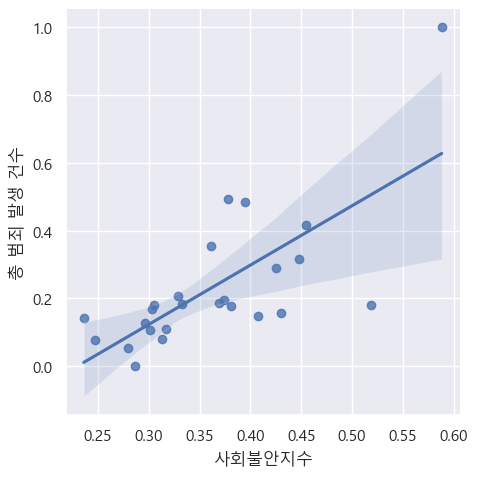

In [67]:
sns.lmplot(data=df_norm1, x='사회불안지수', y='총 범죄 발생 건수')

- 사회불안지수가 높을수록 범죄 발생 건수도 증가하는 추세가 보임.

- 단순한 시각적 추세선만 봐도 정비례 관계로 해석 가능.

- 중간에 약간 퍼진 부분도 있지만, 대체로 우상향 추세.

In [68]:
from scipy.stats import pearsonr


In [69]:

r, p = pearsonr(df_norm1['사회불안지수'], df_norm1['총 범죄 발생 건수'])
print(f"상관계수 (r): {r:.2f}, p-value: {p:.4f}")


상관계수 (r): 0.72, p-value: 0.0001


상관계수 (r = 0.72):
→ 매우 강한 양의 상관관계
→ 사회불안지수가 높을수록 총 범죄 발생 건수도 확실히 증가하는 경향

p-value = 0.0001 (< 0.05):
→ 이 상관관계는 통계적으로 유의미함
→ 우연히 나온 결과일 가능성이 거의 없음

사회불안지수와 자치구별 총 범죄 발생 건수 간의 피어슨 상관계수를 분석한 결과, 상관계수 r = 0.72, p = 0.0001로 나타났다. 이는 두 변수 간에 매우 강한 양의 상관관계가 있으며, 통계적으로도 **유의미함(p < 0.05)**을 보여준다. 따라서 사회적 불안 수준이 높은 자치구일수록 실제 범죄 발생 건수도 높다는 해석이 가능하다.

In [70]:
# df_norm1 내보내기
df_norm1.to_csv('members/조준혁/정규화1.csv', encoding='utf-8-sig', index=True)

In [71]:
# 갑자기 석연찮은 부분이 생긴 것은 
# 아무리 정규화한다고 하더라도 결국 사람 수의 영향을 받는다는 것
# 그러므로 모두 비율화를 해줘야겠다는 결론을 내림
# 현재 원본 데이터프레임을 확인
merged7_df.head()

,자치구별,인구소계,봉사활동 등록률,이혼율,1인가구수(남자),1인가구수(여자),1인가구수(남녀총합),초등학교 학업중단율,중학교 학업중단율,고등학교 학업중단율,소계(10만명당자살률),남자(10만명당자살률),여자(10만명당자살률),등록외국인 소계,외국인 남자 총합,외국인 여자 총합,청소년비행 신고,총 범죄 발생 건수
0,종로구,139417,45.09,1.43,14040,15294,29334,2.09,1.37,2.19,24.5,29.9,19.5,11182,4597,6585,135,9223
1,중구,121312,33.53,1.62,13574,14719,28293,2.64,1.73,2.70,29.4,43.3,16.3,10420,4873,5547,179,9793
2,용산구,213151,26.23,1.46,19436,23046,42482,4.18,1.96,1.85,21.7,28.4,15.4,14540,7842,6698,99,9042
3,성동구,277361,27.77,1.23,23464,24647,48111,1.91,0.85,1.67,23.1,32.7,14.0,7177,2966,4211,345,7367
4,광진구,335554,27.17,1.34,34355,37604,71959,1.43,1.08,1.54,27.2,39.8,15.6,15355,6167,9188,837,9688


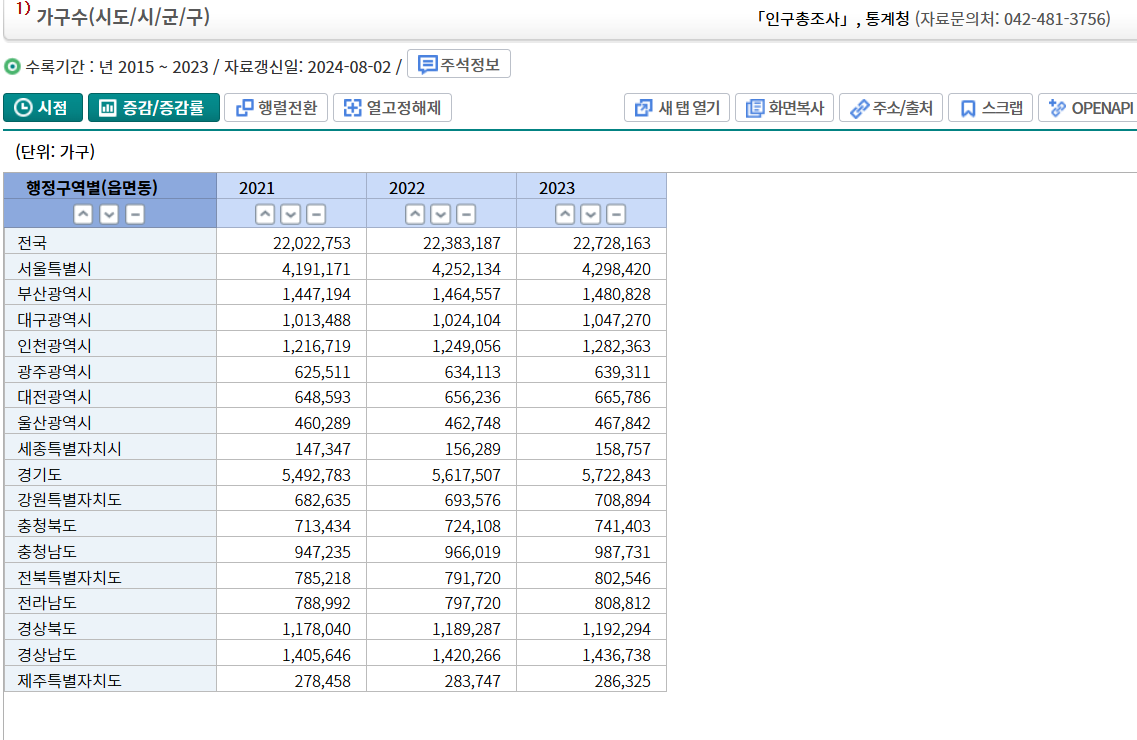

총 가구수는 통계청의 자료. 최신 1인 가구수와 같은 2023데이터를 기준으로 함

In [72]:
total = merged7_df['인구소계'].sum()
print("인구소계 합계:", total)

인구소계 합계: 9386034


In [73]:
# 생각해보니 강력범죄 컬럼을 만들어 추가해야함
df_crime.head()

,자치구별,살인기수,살인미수등,강도,강간,유사강간,강제추행,기타 강간 강제추행등,방화,절도범죄,...,마약범죄,보건범죄,환경범죄,교통범죄,노동범죄,안보범죄,선거범죄,병역범죄,기타범죄,총 범죄 발생 건수
0,종로구,2,1,5,25,10,204,0,4,1173,...,100,119,1,657,4,11,2,22,1650,9223
1,중구,0,3,6,30,4,182,0,13,1523,...,73,108,0,652,3,4,3,18,1612,9793
2,용산구,1,2,3,45,4,195,0,16,971,...,200,102,1,1076,4,3,0,30,1817,9042
3,성동구,1,1,2,22,6,92,0,4,891,...,95,29,1,935,3,1,2,39,1283,7367
4,광진구,0,2,5,42,9,188,0,5,1619,...,100,53,0,850,1,0,5,65,1556,9688


In [74]:
# 강력범죄에 포함될 컬럼들
crime_cols = ['살인기수', '살인미수등', '강도', '강간', '유사강간', '강제추행', '기타 강간 강제추행등', '방화']

# 컬럼 합산하여 '강력범죄'라는 새로운 컬럼 생성
df_crime['강력범죄'] = df_crime[crime_cols].sum(axis=1)

# 결과 확인
print(df_crime[['자치구별', '강력범죄']].head())

  자치구별  강력범죄
0  종로구   251
1   중구   238
2  용산구   266
3  성동구   128
4  광진구   251


In [75]:
# crime_df1을 만든다
crime_df1 = df_crime[['자치구별', '강력범죄']]
crime_df1.head()

,자치구별,강력범죄
0,종로구,251
1,중구,238
2,용산구,266
3,성동구,128
4,광진구,251


In [76]:
# 이후 merge
merged8_df = merged7_df.merge(crime_df1, on='자치구별', how='inner')
# merged8_df.head()

In [77]:
# merged8_df.head()

In [78]:
merged8_df['인구 비율'] = (merged8_df['인구소계'] / 9386034)* 100
merged8_df['청소년비행_비율'] = (merged8_df['청소년비행 신고'] / merged7_df['인구소계']) * 100000  # 10만명당
merged8_df['1인가구_비율'] = (merged8_df['1인가구수(남녀총합)'] / 4298420) * 100
merged8_df['1인가구_비율(여성)'] = (merged8_df['1인가구수(여자)'] / 4298420) * 100
merged8_df['1인가구_비율(남성)'] = (merged8_df['1인가구수(남자)'] / 4298420) * 100
merged8_df['외국인비율'] = (merged8_df['등록외국인 소계'] / merged7_df['인구소계']) * 100


# 만든 강력범죄도 추가
merged8_df['총범죄율'] = (merged8_df['총 범죄 발생 건수'] / merged7_df['인구소계']) * 100000
merged8_df['강력범죄율'] = (merged8_df['강력범죄'] / merged7_df['인구소계']) * 100000

# 확인 
# merged8_df.head()

In [79]:
# 다시 정규화한다
# 정규화할 컬럼 목록
cols_to_normalize = ['인구 비율','총범죄율', '강력범죄율','이혼율', '소계(10만명당자살률)', '1인가구_비율', '1인가구_비율(여성)' , '1인가구_비율(남성)','봉사활동 등록률', '외국인비율','청소년비행_비율', '초등학교 학업중단율', '중학교 학업중단율', '고등학교 학업중단율']

df_norm2 = merged8_df.copy()


# 정규화
scaler = MinMaxScaler()
df_norm2[cols_to_normalize] = scaler.fit_transform(df_norm2[cols_to_normalize])

# 봉사활동 역정규화
df_norm2['봉사활동_역정규화'] = 1 - df_norm2['봉사활동 등록률']

In [80]:
# df_norm2.head()

In [81]:
# df_norm2 내보내기
df_norm2.to_csv('members/조준혁/정규화2.csv', encoding='utf-8-sig', index=True)

In [82]:
# 통합 지표 계산 (평균 기준)
df_norm2['사회불안지수'] = df_norm2[['인구 비율','총범죄율', '강력범죄율','이혼율', '소계(10만명당자살률)', '1인가구_비율', '1인가구_비율(여성)' , '1인가구_비율(남성)','봉사활동 등록률', '외국인비율','청소년비행_비율', '초등학교 학업중단율', '중학교 학업중단율', '고등학교 학업중단율']].mean(axis=1)

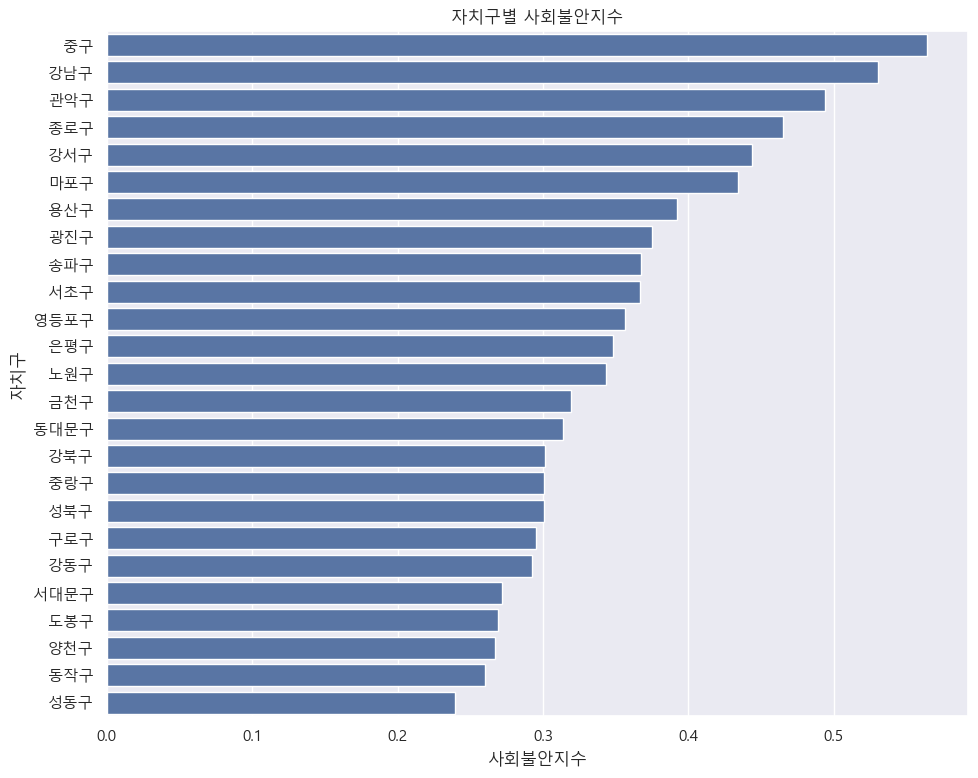

In [83]:
# 자치구별 사회불안지수 막대그래프
plt.figure(figsize=(10, 8))
sns.barplot(data=df_norm2.sort_values('사회불안지수', ascending=False),
            y='자치구별', x='사회불안지수')
plt.title('자치구별 사회불안지수')
plt.xlabel('사회불안지수')
plt.ylabel('자치구')
plt.tight_layout()
plt.show()


In [84]:
# 상관계수 히트맵
# sns.heatmap(df_norm2[['인구 비율','총범죄율', '강력범죄율','이혼율', '소계(10만명당자살률)', '1인가구_비율', '1인가구_비율(여성)' , '1인가구_비율(남성)','봉사활동 등록률', '외국인비율','청소년비행_비율', '초등학교 학업중단율', '중학교 학업중단율', '고등학교 학업중단율']].corr(), 
#             annot=True, cmap='coolwarm')
# plt.title('사회불안 관련 변수 간 상관관계')
# plt.show()


In [85]:

# 각 변수와 범죄 발생 건수 간의 관계를 산점도 + 회귀선 형태로 시각화
# for var in ['인구 비율', '이혼율', '소계(10만명당자살률)', '1인가구_비율', '1인가구_비율(여성)' , '1인가구_비율(남성)','봉사활동 등록률', '외국인비율','청소년비행_비율', '초등학교 학업중단율', '중학교 학업중단율', '고등학교 학업중단율']:
#     sns.lmplot(data=df_norm2, x=var, y='총 범죄 발생 건수')
#     plt.title(f'{var} vs 범죄건수')
#     plt.show()

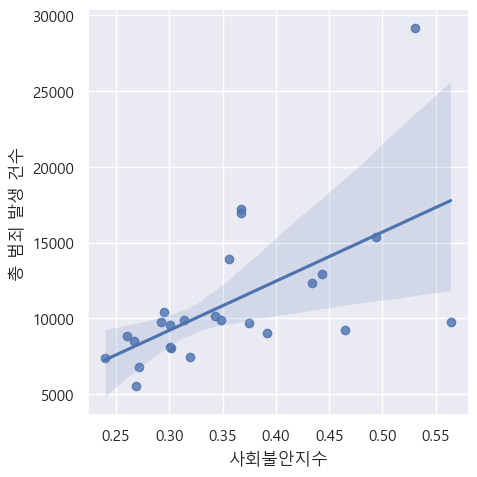

In [86]:
# 사회불안지수와 범죄율
sns.lmplot(data=df_norm2, x='사회불안지수', y='총 범죄 발생 건수')

In [87]:
# 피어슨 상관계수 확인
r, p = pearsonr(df_norm2['사회불안지수'], df_norm2['총 범죄 발생 건수'])
print(f"상관계수 (r): {r:.2f}, p-value: {p:.4f}")

상관계수 (r): 0.59, p-value: 0.0018


In [88]:
# 피어슨 상관계수 확인2
r, p = pearsonr(df_norm2['사회불안지수'], df_norm2['총범죄율'])
print(f"상관계수 (r): {r:.2f}, p-value: {p:.4f}")

상관계수 (r): 0.77, p-value: 0.0000


In [89]:
# 피어슨 상관계수 확인3
r, p = pearsonr(df_norm2['사회불안지수'], df_norm2['강력범죄율'])
print(f"상관계수 (r): {r:.2f}, p-value: {p:.4f}")

상관계수 (r): 0.79, p-value: 0.0000


In [90]:
# csv로 내보낸다.
merged7_df.to_csv('members/조준혁/합친거7.csv', encoding='utf-8-sig', index=True)

merged8_df.to_csv('members/조준혁/합친거8.csv', encoding='utf-8-sig', index=True)

### 비율화 변경

In [91]:
# 비율화에 대한 문제가 있는 것 같음. 전체 가구 수로 1인가구를 나눌 경우 원래와 크게 다르지 않으므로 자치구의 가구로 나누는 것이 합당하다
# 따라서 가구수에 대한 전처리도 진행하도록 함
df_home = pd.read_csv('data/processed/인구__가구_및_주택_시군구.csv')
# df_home.head()

In [92]:
# 데이터 확인 결과 가구-계 (가구) 라는 컬럼에 자치구별 가구 수 통계가 있었음
home_df = df_home[['자치구별','가구-계 (가구)']]
# home_df.head()

In [93]:
merged9_df = merged8_df.merge(home_df, on='자치구별', how='inner')
# merged9_df.head()

In [94]:
# csv로 내보낸다.
merged9_df.to_csv('members/조준혁/합친거9.csv', encoding='utf-8-sig', index=True)

In [95]:
merged9_df.head()

,자치구별,인구소계,봉사활동 등록률,이혼율,1인가구수(남자),1인가구수(여자),1인가구수(남녀총합),초등학교 학업중단율,중학교 학업중단율,고등학교 학업중단율,...,강력범죄,인구 비율,청소년비행_비율,1인가구_비율,1인가구_비율(여성),1인가구_비율(남성),외국인비율,총범죄율,강력범죄율,가구-계 (가구)
0,종로구,139417,45.09,1.43,14040,15294,29334,2.09,1.37,2.19,...,251,1.485366,96.831807,0.682437,0.355805,0.326632,8.020543,6615.405582,180.035433,70217
1,중구,121312,33.53,1.62,13574,14719,28293,2.64,1.73,2.70,...,238,1.292473,147.553416,0.658219,0.342428,0.315790,8.589422,8072.573200,196.188341,64325
2,용산구,213151,26.23,1.46,19436,23046,42482,4.18,1.96,1.85,...,266,2.270938,46.445947,0.988317,0.536150,0.452166,6.821455,4242.063138,124.794160,103826
3,성동구,277361,27.77,1.23,23464,24647,48111,1.91,0.85,1.67,...,128,2.955039,124.386630,1.119272,0.573397,0.545875,2.587602,2656.105220,46.149242,127950
4,광진구,335554,27.17,1.34,34355,37604,71959,1.43,1.08,1.54,...,251,3.575035,249.438242,1.674080,0.874833,0.799247,4.576015,2887.165702,74.801671,168848


### 비율화를 다시 진행한다

In [96]:
merged9_df['인구 비율'] = (merged9_df['인구소계'] / 9386034)* 100
merged9_df['청소년비행_비율'] = (merged9_df['청소년비행 신고'] / merged9_df['인구소계']) * 100000  # 10만명당
merged9_df['1인가구_비율'] = (merged9_df['1인가구수(남녀총합)'] / merged9_df['가구-계 (가구)']) * 100
merged9_df['1인가구_비율(여성)'] = (merged9_df['1인가구수(여자)'] / merged9_df['가구-계 (가구)']) * 100
merged9_df['1인가구_비율(남성)'] = (merged9_df['1인가구수(남자)'] / merged9_df['가구-계 (가구)']) * 100
merged9_df['외국인비율'] = (merged9_df['등록외국인 소계'] / merged9_df['인구소계']) * 100


# 만든 강력범죄도 추가
merged9_df['총범죄율'] = (merged9_df['총 범죄 발생 건수'] / merged9_df['인구소계']) * 100000
merged9_df['강력범죄율'] = (merged9_df['강력범죄'] / merged9_df['인구소계']) * 100000

### 정규화도 다시 진행한다.

In [97]:
# 정규화할 컬럼 목록
cols_to_normalize = ['인구 비율','총범죄율', '강력범죄율','이혼율', '소계(10만명당자살률)', '1인가구_비율', '1인가구_비율(여성)' , '1인가구_비율(남성)','봉사활동 등록률', '외국인비율','청소년비행_비율', '초등학교 학업중단율', '중학교 학업중단율', '고등학교 학업중단율']

df_norm3 = merged9_df.copy()


# 정규화
scaler = MinMaxScaler()
df_norm3[cols_to_normalize] = scaler.fit_transform(df_norm3[cols_to_normalize])

# 봉사활동 역정규화
df_norm3['봉사활동_역정규화'] = 1 - df_norm3['봉사활동 등록률']

In [98]:
# df_norm3 내보내기
df_norm3.to_csv('members/조준혁/정규화3.csv', encoding='utf-8-sig', index=True)

In [99]:
# 통합 지표 계산 (평균 기준)
# 범죄율과 강력범죄율은 포함되면 안될 것 같아서 사회불안지수에서는 제외함
df_norm3['사회불안지수'] = df_norm3[['인구 비율', '이혼율', '소계(10만명당자살률)', '1인가구_비율', '1인가구_비율(여성)' , '1인가구_비율(남성)','봉사활동 등록률', '외국인비율','청소년비행_비율', '초등학교 학업중단율', '중학교 학업중단율', '고등학교 학업중단율']].mean(axis=1)

범죄율/강력범죄율은 실제 결과, 예측하고 싶은 대상이며 사회불안지수는 그 결과를 예측하거나 설명하기 위한 지표인데
포함하면 예측 대상이 원인 안에 섞이는 셈

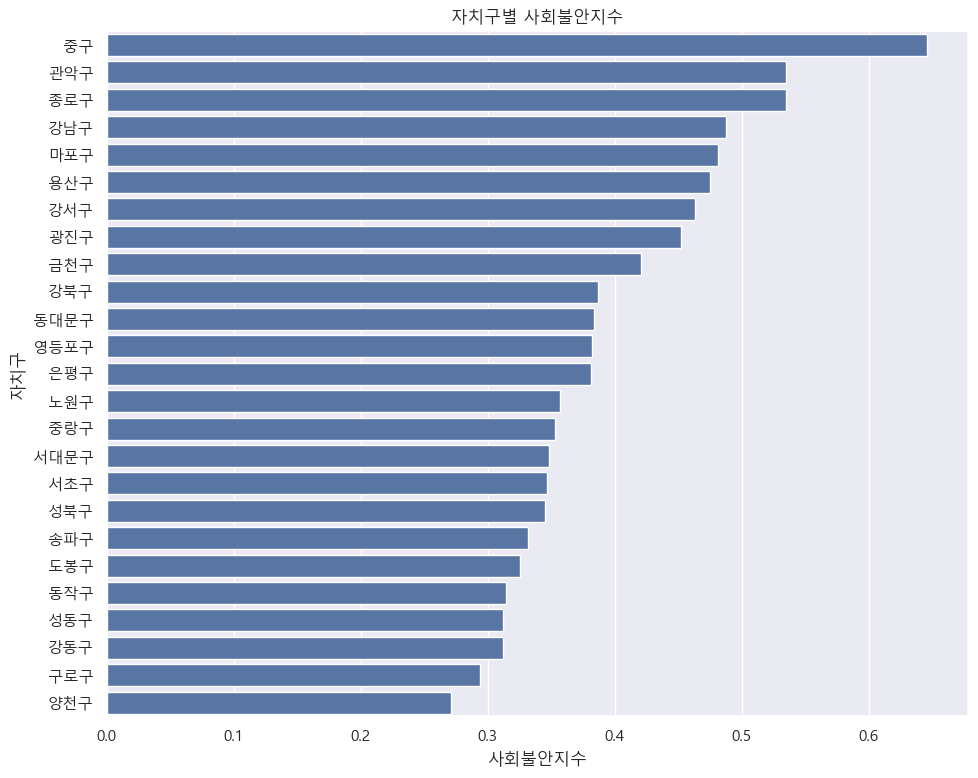

In [100]:
# 자치구별 사회불안지수 막대그래프
plt.figure(figsize=(10, 8))
sns.barplot(data=df_norm3.sort_values('사회불안지수', ascending=False),
            y='자치구별', x='사회불안지수')
plt.title('자치구별 사회불안지수')
plt.xlabel('사회불안지수')
plt.ylabel('자치구')
plt.tight_layout()
plt.show()

- 각 자치구가 가진 사회적 불안 수준을 상대적으로 비교
(사회불안지수는 이혼율, 청소년비행율, 학업중단율, 1인가구 비율 등으로 계산된 값)
- 중구는 모든 자치구 중 사회불안지수가 가장 높음
→ 구조적 또는 복합적 사회문제가 집중된 지역일 가능성
- 관악구, 종로구, 강남구도 상위권
→ 강남구가 포함된 것은 흥미롭고, 고립된 1인가구, 학업 중단 등의 요소가 반영됐을 가능성
- 양천구, 구로구, 강동구 등은 사회불안지수가 낮음
→ 상대적으로 안정적인 사회환경을 가졌다고 해석 가능

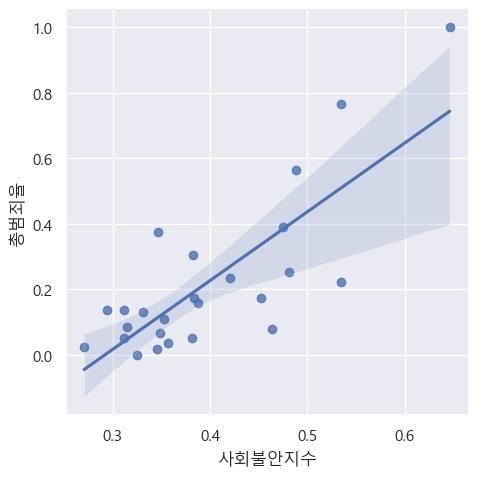

In [101]:
# 사회불안지수와 범죄율
sns.lmplot(data=df_norm3, x='사회불안지수', y='총범죄율')
plt.show()

- 전반적으로 우상향 추세가 분명함
→ 사회불안지수가 높아질수록 범죄 발생 건수도 증가하는 경향

- 회귀선은 뚜렷한 기울기를 가지며, 설명력도 꽤 있는 것으로 보임

- 일부 자치구는 **사회불안지수는 낮지만 범죄건수가 높은 이상치(Outlier)**로 보임



In [102]:
# 피어슨 상관계수 확인
r, p = pearsonr(df_norm3['사회불안지수'], df_norm3['총범죄율'])
print(f"상관계수 (r): {r:.2f}, p-value: {p:.4f}")

상관계수 (r): 0.79, p-value: 0.0000


In [103]:
# 피어슨 상관계수 확인2
r, p = pearsonr(df_norm3['사회불안지수'], df_norm3['강력범죄율'])
print(f"상관계수 (r): {r:.2f}, p-value: {p:.4f}")

상관계수 (r): 0.81, p-value: 0.0000


- 통계적으로 유의미한 양의 상관관계

- 사회불안지수 ↑ → 범죄율 ↑	사회 불안 요인(예: 학업중단율, 이혼율 등)이 실제 범죄로 이어질 가능성을 시사
- 이상치 존재	단순히 사회불안 요인만으로 설명되지 않는 추가적 요인이 존재할 수도 있음 (ex. 유동인구, 상업지구, 주거밀도 등)

#### 사회불안지수 변수들 간 중복/독립성 확인을 위한 히트맵

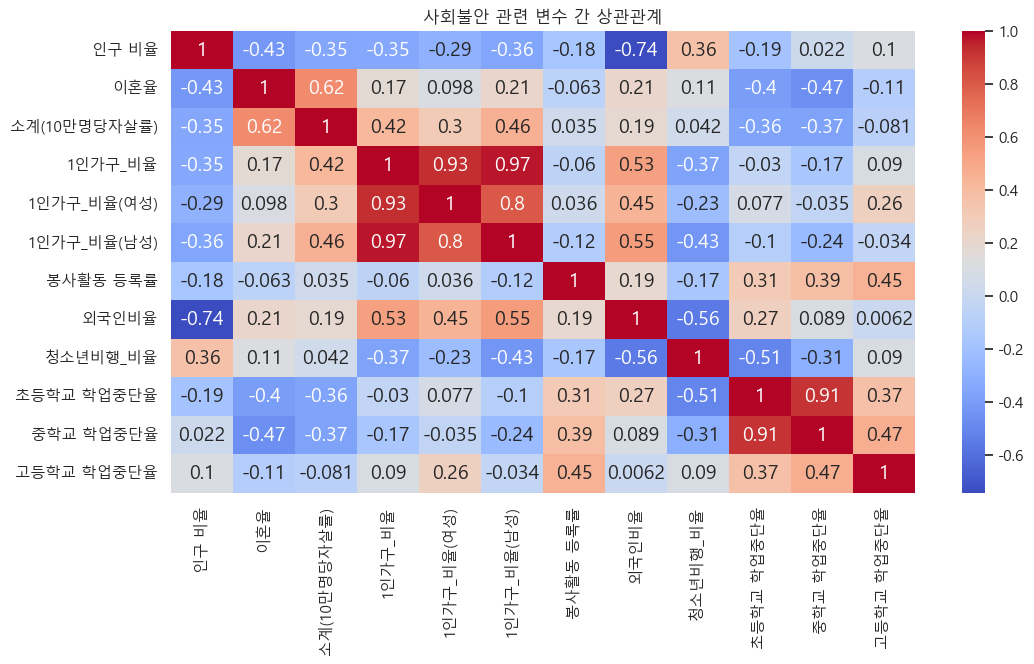

In [104]:
# 상관계수 히트맵
sns.heatmap(df_norm3[['인구 비율','이혼율', '소계(10만명당자살률)', '1인가구_비율', '1인가구_비율(여성)' , '1인가구_비율(남성)','봉사활동 등록률', '외국인비율','청소년비행_비율', '초등학교 학업중단율', '중학교 학업중단율', '고등학교 학업중단율']].corr(), 
            annot=True, cmap='coolwarm')
plt.title('사회불안 관련 변수 간 상관관계')
plt.show()


- 1인가구 관련 변수들 셋 중 하나만 남기고 나머지 제거 필요. 1인가구_비율만 사용 (전체 대표값)

- 학업 중단율은 초등 + 중학교는 너무 유사. 중학교 학업중단율 하나만 쓰거나 중학교와 고등학교만 선택하는 게 더 정보 분산 효과 있음

- 외국인 비율 ↔ 인구 비율. 외국인 많은 지역일수록 자치구 인구가 적은 경향 → 서로 보완적 관계.
- 둘 다 유지 가능하지만, 외국인비율은 강한 상관성 있는 다른 변수도 많음

- 봉사활동 등록률은 전반적으로 모든 변수와 상관이 매우 약함. → 독립성 높음, 지표에 포함 시 분산성 확보에 도움

- 따라서 초등학교와 남녀각각을 지운다. 

"사회불안지수에 포함된 변수들 간의 상관관계를 분석한 결과,
일부 변수들(예: 1인가구_비율, 1인가구_비율(남성))은 매우 높은 상관관계를 보이며 중복성이 확인되어 제거하였고,
최종적으로 독립성이 확보된 6~7개 지표만을 포함하여 사회불안지수를 재정의하였다."

In [105]:
# 통합 지표 계산 (평균 기준)
# 초등학교와 1인가구 남녀를 지웠다. 
df_norm3['사회불안지수re'] = df_norm3[['인구 비율', '이혼율', '소계(10만명당자살률)', '1인가구_비율', '봉사활동 등록률', '외국인비율','청소년비행_비율', '중학교 학업중단율', '고등학교 학업중단율']].mean(axis=1)

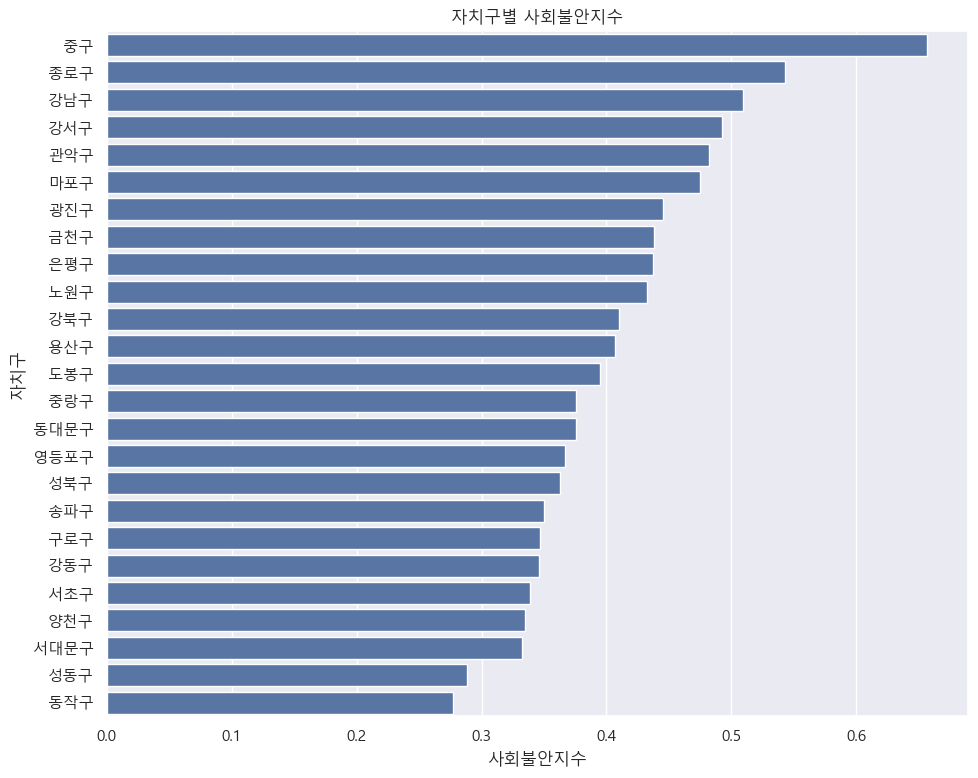

In [106]:
# 자치구별 사회불안지수 막대그래프
plt.figure(figsize=(10, 8))
sns.barplot(data=df_norm3.sort_values('사회불안지수re', ascending=False),
            y='자치구별', x='사회불안지수re')
plt.title('자치구별 사회불안지수')
plt.xlabel('사회불안지수')
plt.ylabel('자치구')
plt.tight_layout()
plt.show()

- 중구 : 여전히 가장 높은 불안 지수 → 구조적 문제 지속 또는 고립된 취약 요인 존재 가능성
- 종로구, 강남구, 강서구:  예상 외의 고위험군 → 1인가구, 학업중단율 등 복합적 요인 가능성
- 동작구, 성동구, 서대문구 등 : 사회불안지수 낮음 → 상대적 안정 지역으로 평가 가능

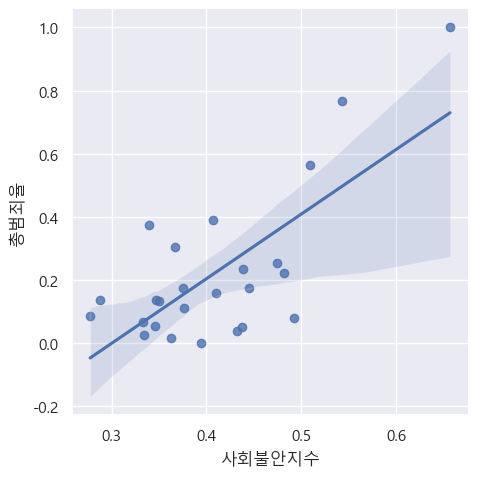

In [107]:
# 사회불안지수와 범죄율
sns.lmplot(data=df_norm3, x='사회불안지수re', y='총범죄율')
plt.xlabel('사회불안지수')
plt.show()

- 사회불안이 높을수록 강력범죄율이 높아지는 경향 존재
- 중간~하위 불안지수 지역은 범죄율이 대부분 낮음, 일부 고위험 자치구만 범죄율 급상승
- 강력범죄율이 비정상적으로 높은 자치구 존재 → 추가 분석 필요

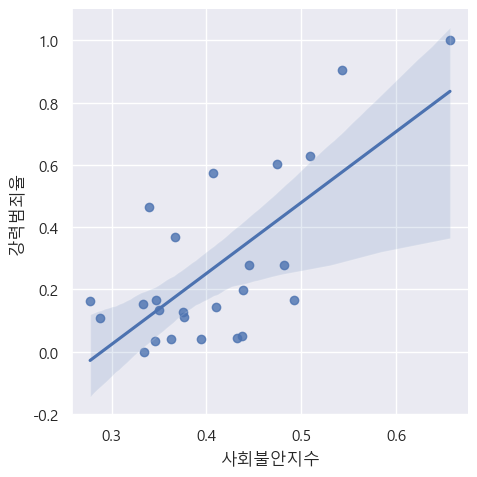

In [108]:
# 사회불안지수와 강력범죄율
sns.lmplot(data=df_norm3, x='사회불안지수re', y='강력범죄율')
plt.xlabel('사회불안지수')
plt.show()

In [109]:
# 피어슨 상관계수 확인
r, p = pearsonr(df_norm3['사회불안지수re'], df_norm3['총범죄율'])
print(f"상관계수 (r): {r:.2f}, p-value: {p:.4f}")

r, p = pearsonr(df_norm3['사회불안지수re'], df_norm3['강력범죄율'])
print(f"상관계수 (r): {r:.2f}, p-value: {p:.4f}")

상관계수 (r): 0.72, p-value: 0.0000
상관계수 (r): 0.71, p-value: 0.0001


In [110]:
from sklearn.linear_model import LinearRegression

# X: 사회불안지수, y: 범죄율
X = df_norm3[['사회불안지수']]
y = df_norm3['총범죄율']  # 혹은 '총 범죄 발생 건수' 등

# 모델 학습
model = LinearRegression()
model.fit(X, y)

# 예측값 및 잔차
y_pred = model.predict(X)
residuals = y - y_pred

# 전체 분산, 설명된 분산, 잔차 분산
total_var = np.var(y)
explained_var = np.var(y_pred)
residual_var = np.var(residuals)

print(f"총 분산: {total_var:.4f}")
print(f"설명된 분산: {explained_var:.4f}")
print(f"잔차(오차) 분산: {residual_var:.4f}")
print(f"설명력(R² 대안): {explained_var / total_var:.4f}")

총 분산: 0.0564
설명된 분산: 0.0351
잔차(오차) 분산: 0.0212
설명력(R² 대안): 0.6235


In [111]:
# X: 사회불안지수, y: 범죄율
X = df_norm3[['사회불안지수re']]
y = df_norm3['총범죄율']  # 혹은 '총 범죄 발생 건수' 등

# 모델 학습
model = LinearRegression()
model.fit(X, y)

# 예측값 및 잔차
y_pred = model.predict(X)
residuals = y - y_pred

# 전체 분산, 설명된 분산, 잔차 분산
total_var = np.var(y)
explained_var = np.var(y_pred)
residual_var = np.var(residuals)

print(f"총 분산: {total_var:.4f}")
print(f"설명된 분산: {explained_var:.4f}")
print(f"잔차(오차) 분산: {residual_var:.4f}")
print(f"설명력(R² 대안): {explained_var / total_var:.4f}")

총 분산: 0.0564
설명된 분산: 0.0294
잔차(오차) 분산: 0.0269
설명력(R² 대안): 0.5220


- 사회불안지수의 정제(= 변수 제거) 이후 상관계수 
r: 0.79 → 0.72
- 결정계수 하락
- 잔차(오차) 분산: 증가
- 정제된 지표가 해석적으론 더 깔끔해졌을 수 있지만, 설명력은 일부 희생된 셈



정규화 및 상관관계 분석 파트는 완성도가 충분히 높으므로, 지금 이 단계에서 마무리하고 다음 분석 단계로 넘어가도록 하겠음.

In [112]:
#우선 df_norm3 확인 후 저장
df_norm3.head()

,자치구별,인구소계,봉사활동 등록률,이혼율,1인가구수(남자),1인가구수(여자),1인가구수(남녀총합),초등학교 학업중단율,중학교 학업중단율,고등학교 학업중단율,...,1인가구_비율,1인가구_비율(여성),1인가구_비율(남성),외국인비율,총범죄율,강력범죄율,가구-계 (가구),봉사활동_역정규화,사회불안지수,사회불안지수re
0,종로구,139417,1.000000,0.558824,14040,15294,29334,0.447090,0.476395,0.585366,...,0.524304,0.624766,0.457454,0.927603,0.767596,0.903840,70217,0.000000,0.534659,0.542955
1,중구,121312,0.501509,0.838235,13574,14719,28293,0.592593,0.630901,1.000000,...,0.605245,0.725786,0.525034,1.000000,1.000000,1.000000,64325,0.498491,0.646026,0.656544
2,용산구,213151,0.186718,0.602941,19436,23046,42482,1.000000,0.729614,0.308943,...,0.492794,0.662901,0.379599,0.775005,0.389072,0.574982,103826,0.813282,0.475381,0.406897
3,성동구,277361,0.253126,0.264706,23464,24647,48111,0.399471,0.253219,0.162602,...,0.371282,0.393768,0.356319,0.236198,0.136128,0.106799,127950,0.746874,0.312016,0.288292
4,광진구,335554,0.227253,0.426471,34355,37604,71959,0.272487,0.351931,0.056911,...,0.555145,0.669705,0.478914,0.489247,0.172980,0.277371,168848,0.772747,0.452123,0.444930


In [113]:
# csv로 내보낸다.
df_norm3.to_csv('members/조준혁/정규화3_수정.csv', encoding='utf-8-sig', index=True)

다중회귀 분석

In [114]:
import statsmodels.api as sm

X = df_norm3[['인구 비율', '이혼율', '소계(10만명당자살률)', '1인가구_비율', '봉사활동 등록률', '외국인비율','청소년비행_비율', '중학교 학업중단율', '고등학교 학업중단율']]
y = df_norm3['총범죄율']  # '총 범죄 발생 건수'

X = sm.add_constant(X)  # 절편 추가
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   총범죄율   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     17.82
Date:                Sun, 01 Jun 2025   Prob (F-statistic):           1.82e-06
Time:                        13:28:19   Log-Likelihood:                 31.212
No. Observations:                  25   AIC:                            -42.42
Df Residuals:                      15   BIC:                            -30.23
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.2643      0.149     -1.771   

강력범죄율과 비교 분석: 전체 범죄 vs 강력범죄에 대한 사회불안지수의 예측력 비교

In [115]:
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

# 전체 범죄
X = df_norm3[['사회불안지수']]
y_total = df_norm3['총범죄율']
model_total = LinearRegression().fit(X, y_total)
r_total, _ = pearsonr(df_norm3['사회불안지수'], y_total)
r2_total = model_total.score(X, y_total)

# 강력 범죄
y_violent = df_norm3['강력범죄율']
model_violent = LinearRegression().fit(X, y_violent)
r_violent, _ = pearsonr(df_norm3['사회불안지수'], y_violent)
r2_violent = model_violent.score(X, y_violent)

print(f"전체 범죄: r = {r_total:.2f}, R² = {r2_total:.2f}")
print(f"강력 범죄: r = {r_violent:.2f}, R² = {r2_violent:.2f}")

전체 범죄: r = 0.79, R² = 0.62
강력 범죄: r = 0.81, R² = 0.66
